# HW 2: Ensemble Learning
# Boosting

We'll first setup the environment

In [1]:
# For the matrix math
import numpy as np
# For data manipulation
import pandas as pd
# For rendering the plots
import matplotlib.pyplot as plt
import pylab as pl
# For shuffling, folding and splitting the train and test data
from sklearn import cross_validation
from sklearn import preprocessing
# For calculating performance metrics
from sklearn.metrics import confusion_matrix, accuracy_score, zero_one_loss
# For classifying verification metrics
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format='svg'
%matplotlib inline

Then load in the data

In [2]:
spam_DF = pd.read_csv('data/spambase.data',header=None)
# spam_DF
# spam_DF.describe()

In [3]:
alcohol_DF = pd.read_csv('data/alcoholism.csv', delim_whitespace=True)
# alcohol_DF
# alcohol_DF.describe()

In [4]:
musicgenre_DF = pd.read_csv('data/genre_classification.txt', delim_whitespace=True)
# musicgenre_DF
# musicgenre_DF.describe()

In [35]:
wine_DF = pd.read_csv('data/wine.data')
# wine_DF
# wine_DF.describe()
# wine_DF.tail()

In [36]:
spam_X = np.matrix(spam_DF[range(0,57)])
spam_y = np.array(spam_DF[57])
spam = {'Lable': 'Spam', 'X': spam_X, 'y': spam_y}

alcohol_X = np.matrix(alcohol_DF[['f1','f2','f3','f4','f5','f6']])
alcohol_y = np.array(alcohol_DF['c'])
alcohol = {'Lable': 'Alcoholism', 'X': alcohol_X, 'y': alcohol_y}

musicgenre_X = np.matrix(musicgenre_DF[['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']])
musicgenre_y = np.array(musicgenre_DF['c'])
musicgenre = {'Lable': 'Music Genre', 'X': musicgenre_X, 'y': musicgenre_y}

wine_X = np.matrix(wine_DF[['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13']])
wine_y = np.array(wine_DF['c'])
wine = {'Lable': 'Alcoholism', 'X': wine_X, 'y': wine_y}

dataSets = [spam, alcohol, musicgenre, wine]

Here we'll be use some primitive baseclasses and some coding guidelines from scikit to make our classifier.

In [7]:
from __future__ import division
import numbers
import itertools
from abc import ABCMeta, abstractmethod
from sklearn.base import ClassifierMixin, BaseEstimator
# Six provides simple utilities for wrapping over differences between Python 2 and Python 3
from sklearn.externals import six
from sklearn.externals.six.moves import xrange
from sklearn.feature_selection.from_model import _LearntSelectorMixin
from sklearn.tree._tree import DTYPE, DOUBLE
from sklearn.utils import array2d, check_random_state, check_arrays, safe_asarray, column_or_1d
from sklearn.utils.fixes import bincount, unique
from sklearn.tree._tree import Tree, Entropy, BestSplitter
from sklearn.ensemble.base import BaseEnsemble

In [8]:
class myDecisionTreeClassifier(six.with_metaclass(ABCMeta, BaseEstimator, _LearntSelectorMixin, ClassifierMixin)):
    
    def __init__(self,
                 # Max depth for Decision Tree
                 max_depth=None,
                 # Min number of samples per split
                 min_samples_split=2,
                 # Min samples per leaf node
                 min_samples_leaf=1,
                 # Max number of features to consider when looking for the best split
                 max_features=None,
                 # Init the random state of the tree
                 random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        # We'll waint until we fit to inti these:
        # Learning criterion for training tree
        self.criterion = None
        # Split method
        self.splitter = None
        # Number of features
        self.n_features_ = None
        # Number of outputs
        self.n_outputs_ = None
        # Labels of classes
        self.classes_ = None
        # Number of classes
        self.n_classes_ = None
        # Tree dataframe
        self.tree_ = None
        
    def fit(self, X, y, check_input=True, sample_weight=None):
        # Poll the randome state from the tree
        random_state = check_random_state(self.random_state)
        # If the data hasn't yet been formated
        if check_input:
            # Then convert the X data
            X, = check_arrays(X, dtype=DTYPE, sparse_format="dense", check_ccontiguous=True)
        # Get the dimentions of X
        n_samples, self.n_features_ = X.shape
        # Make sure that y is a 1d and not a id.T
        y = np.atleast_1d(y)
        # If our output is 1d
        if y.ndim == 1:
            # Reshape y to preserve the data contiguity
            y = np.reshape(y, (-1, 1))
        # Get the number of outputs
        self.n_outputs_ = y.shape[1]
        y = np.copy(y)
        # Make a container for all unique classes
        self.classes_ = []
        # Make a container for number of instances of each unique classe
        self.n_classes_ = []
        # For each output of y
        for k in xrange(self.n_outputs_):
            # Get the unique classe lables and an array of indexs pointing to the lable
            classes_k, y[:, k] = unique(y[:, k], return_inverse=True)
            # Store the unique classe lables
            self.classes_.append(classes_k)
            # And store the unique classe lables' length
            self.n_classes_.append(classes_k.shape[0])
        # Lets make this numpy array type ints for speed
        self.n_classes_ = np.array(self.n_classes_, dtype=np.intp)
        if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
            y = np.ascontiguousarray(y, dtype=DOUBLE)
        # Check parameters
        # If no maxdepth was given
        max_depth = (2 ** 31) - 1 if self.max_depth is None else self.max_depth
        # If defult was given 
        if isinstance(self.max_features, six.string_types):
            # then set it to the sqrt of number of features 
            max_features = max(1, int(np.sqrt(self.n_features_)))
        # If None was given 
        elif self.max_features is None:
            # Just use all of them
            max_features = self.n_features_
        # Otherwise
        else:
            # Use whats given
            max_features = self.max_features
        # We we we're given a sample weight
        if sample_weight is not None:
            # Then  we'll nedd to make sure its double precision
            if (getattr(sample_weight, "dtype", None) != DOUBLE or not sample_weight.flags.contiguous):
                sample_weight = np.ascontiguousarray(sample_weight, dtype=DOUBLE)
        min_samples_split = self.min_samples_split
        criterion = self.criterion
        # If we have not yet inti our tree criterion
        if criterion is None:
            # Lets inti our entropy criterion
            criterion = Entropy(self.n_outputs_, self.n_classes_)
        splitter = self.splitter
        # If we have not yet inti our tree splitter
        if splitter is None:
            # Lets inti our best binary splitter
            splitter = BestSplitter(criterion, max_features, self.min_samples_leaf, random_state)
        # We'll save these so we don't have to init them agian a second time for retraining
        self.criterion_ = criterion
        self.splitter_ = splitter
        # Now lets init
        self.tree_ = Tree(self.n_features_, self.n_classes_, self.n_outputs_, splitter, max_depth, min_samples_split, self.min_samples_leaf, random_state)
        # and fit our tree database
        self.tree_.build(X, y, sample_weight=sample_weight)
        # If we only have one output
        if self.n_outputs_ == 1:
            # Then just save the first class
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]
        # Then save our tree
        return self

    def predict(self, X):
        """Predict class for a given X"""
        # Make sure the data is DTYPE for the tree and is 2D
        if getattr(X, "dtype", None) != DTYPE or X.ndim != 2:
            X = array2d(X, dtype=DTYPE)
        # Get the dimentions of X
        n_samples, n_features = X.shape
        # Predict class from tree database
        proba = self.tree_.predict(X)
        # If we only have one output
        if self.n_outputs_ == 1:
            # Then use the index of the max prob to pick the class from classes_
            return self.classes_.take(np.argmax(proba, axis=1), axis=0)
        # If we were trained with multiple outputs
        else:
            # Make a empty 2D array to hold predictions
            predictions = np.zeros((n_samples, self.n_outputs_))
            # For each output
            for k in xrange(self.n_outputs_):
                # Then use the index of the max prob to pick the class from classes_
                predictions[:, k] = self.classes_[k].take(np.argmax(proba[:, k], axis=1), axis=0)
            # Return the results
            return predictions

    def predict_proba(self, X):
        """Predict class probabilities from the given X"""
        # Make sure the data is DTYPE for the tree and is 2D
        if getattr(X, "dtype", None) != DTYPE or X.ndim != 2:
            X = array2d(X, dtype=DTYPE)
        # Get the dimentions of X
        n_samples, n_features = X.shape
        # Predict class from tree database
        proba = self.tree_.predict(X)
        # If we only have one output
        if self.n_outputs_ == 1:
            # Grab the predictions for the avalable classes
            proba = proba[:, :self.n_classes_]
            # Generate a normalizer from all the proba weights
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            # Remap all of the zero normalizer elemnts to one
            # This is so just we can avoid deviding by zero
            normalizer[normalizer == 0.0] = 1.0
            # Now normilize the proba by the total weight sum of each sample
            proba /= normalizer
            # Return the results
            return proba
        # If we were trained with multiple outputs
        else:
            # Make a empty container to hold all proba
            all_proba = []
            # For each output
            for k in xrange(self.n_outputs_):
                # Grab the predictions for the avalable classes
                proba_k = proba[:, k, :self.n_classes_[k]]
                # Generate a normalizer from all the proba weights
                normalizer = proba_k.sum(axis=1)[:, np.newaxis]
                # Remap all of the zero normalizer elemnts to one
                # This is so just we can avoid deviding by zero
                normalizer[normalizer == 0.0] = 1.0
                # Now normilize the proba by the total weight sum of each sample
                proba_k /= normalizer
                # Return the results
                all_proba.append(proba_k)
            # Return the results
            return all_proba

## Boosting

The implementation of AdaBoost here will be the SAMME implementation specifically, as one of datasets use is multi class and will require the small modification to enable multi class support. The main difference here will be adding the $\log(K-1)$ term to step C in the original AdaBoost.M1 algorithm, where K is the number of unique classes in the dataset.

To make some nice plotting error functions to generate all the tests needed for rendering figures.

In [9]:
def plot_error2(clf, base_estimator, X_TD, X_TtD, y_TD, y_TtD, n_estimators, base_name):
    
    data = {}
    
    ada_err = np.zeros((n_estimators,))
    for i, y_pred in enumerate(clf.staged_predict(X_TtD)):
        ada_err[i] = zero_one_loss(y_pred, y_TtD)
    data['AdaBoost ' + base_name + ' Test Error'] = {'x': np.arange(n_estimators) + 1, 'y': ada_err}
    
    ada_err_train = np.zeros((n_estimators,))
    for i, y_pred in enumerate(clf.staged_predict(X_TD)):
        ada_err_train[i] = zero_one_loss(y_pred, y_TD)
    data['AdaBoost ' + base_name + ' Train Error'] = {'x': np.arange(n_estimators) + 1, 'y': ada_err_train}
    
    base_err = 1.0 - base_estimator.score(X_TtD, y_TtD)
    data['Decision ' + base_name + ' Error'] = {'x': [1, n_estimators], 'y': [base_err] * 2}
    
    return data

In [10]:
class myAdaBoostClassifier(six.with_metaclass(ABCMeta, BaseEnsemble, ClassifierMixin)):
    """AdaBoost Classifier"""

    def __init__(self,
                 # base estimator used durring boosting, well use a stup by defult
                 base_estimator=myDecisionTreeClassifier(max_depth=1),
                 # Maximum number of estimators to be used
                 n_estimators=500,
                 # Learning rate for each estimators
                 learning_rate=1.,
                 # BaseEnsemble params, None used
                 estimator_params=tuple(),
                 # Random state used for init for base_estimator
                 random_state=None):
        super(myAdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            estimator_params=estimator_params)
        self.learning_rate = learning_rate
        self.random_state = random_state

    def fit(self, X, y):
        """Fit a boosted classifier given training set X and y"""
        # Get the dimentions of X
        n_samples, self.n_features_ = X.shape
        # Firs step in SAMME Adaboost is to initialize weights to 1 / n_samples
        sample_weight = np.empty(n_samples, dtype=np.float)
        sample_weight[:] = 1. / n_samples
        # Next is to do some house keeping and clear any previous fit results
        # and make a new container for estimators
        self.estimators_ = []
        # We'll make a container for each weights
        self.estimator_weights_ = np.zeros(self.n_estimators, dtype=np.float)
        # And for estimator errors
        self.estimator_errors_ = np.ones(self.n_estimators, dtype=np.float)
        # Now itertivly for each n_estimators as planned
        for iboost in xrange(self.n_estimators):
            # Proform the boosting step on the current estimator
            # Given the data set and the current sample_weight
            sample_weight, estimator_weight, estimator_error = self.boost(iboost, X, y, sample_weight)
            # The new sample_weight will be used to determine if we are finished,
            # We'll terminate early if no new weight were returned
            if sample_weight is None:
                # This means we're doing as bad as just as random guessing
                break
            # Lets save the new estimator weight
            self.estimator_weights_[iboost] = estimator_weight
            # And the new estimator estimator error
            self.estimator_errors_[iboost] = estimator_error
            # If our estimator error is zero
            if estimator_error == 0:
                # We need not boost any further
                break
            # Now lets get the sum of the sample weights
            sample_weight_sum = np.sum(sample_weight)
            # If the sum of sample weights is non-positive
            if sample_weight_sum <= 0:
                # Then this is not good
                # And we should probably stop this numerical instability
                break
            # If we are still not at the last estimator
            if iboost < self.n_estimators - 1:
                # We need to keep our sample weight normalized
                sample_weight /= sample_weight_sum
        # Return our boosted classifier
        return self

    def boost(self, iboost, X, y, sample_weight):
        """Run a single boost iteration"""
        # Lets make a new estimator from out base estimator chosen durring init
        estimator = self._make_estimator()
        # Now lets set it's random state with our own
        estimator.set_params(random_state=self.random_state)
        # And let it train off the data and sample weight given
        # This is step "A" in the AdaBoost Algorithm
        estimator.fit(X, y, sample_weight=sample_weight)
        # Now lets see how we did by getting some predictions
        y_predict = estimator.predict(X)
        # Now lets get a binary list of incorrectly classified samples
        incorrect = y_predict != y
        # If this is the first boosting iteration
        if iboost == 0:
            # Then we can use our base estimator to get the unique classes
            self.classes_ = getattr(estimator, 'classes_', None)
            # And the number of occurrences of each class
            self.n_classes_ = len(self.classes_)
        # Now lets get the e rror fraction by taking a weighted average of incorrect samples
        # This is step "B" in the AdaBoost Algorithm
        estimator_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))
        # We'll do a realaty check and see if classification is perfect
        if estimator_error <= 0:
            # If it is, we needn't go any further
            # and just return the sample_weight, 
            # and estimator_weight of 1.0
            # and an estimator_error of 0.0
            return sample_weight, 1.0, 0.0
        # We'll do another realaty check and see if classification rate is worthless
        n_classes = self.n_classes_
        if estimator_error >= 1.0 - (1.0 / n_classes):
            # Let just stop if the error is as bad as random guessing
            self.estimators_.pop(-1)
            # We'll use None to signify our failure
            return None, None, None
        # Now lets start to boost weight with AdaBoost's step "C"
        estimator_weight = np.log((1. - estimator_error) / estimator_error)
        # But because we are doing multi-class data sets,
        # We'll have to use the the SAMME adaptation to calculate estimator weight
        # Note that is K = 2, this would be the same as the orginal AdaBoost
        estimator_weight += np.log(n_classes - 1.)
        # While we're at it, we might as well add in a learning rate parameter
        estimator_weight *= self.learning_rate
        # If this is the last estimators to boost
        if not iboost == self.n_estimators - 1:
            # Then lets apply the boosted estimator weight with AdaBoost's step "D"
            mask =  ((sample_weight > 0) | (estimator_weight < 0))
            # To calculate the new sample weight
            sample_weight *= np.exp(estimator_weight * incorrect * mask)
        # Return the weights and error
        return sample_weight, estimator_weight, estimator_error

    def predict(self, X):
        """Predict classes for a given X"""
        # Make sure we're working with numpy arrays here
        X = np.asarray(X)
        # Get the number of classes
        n_classes = self.n_classes_
        # Grab a reshaped list of classes for estimator comparison
        classes = self.classes_[:, np.newaxis]
        # Keep track of predictions
        pred = 0
        # For each estimator
        for estimator, w in zip(self.estimators_, self.estimator_weights_):
            # Make a prediction for all samples and apply it's estimator weight
            # Then add it to the running predictions
            pred += (estimator.predict(X) == classes).T * w
        # Then normilize the predictions by the total estimator weight for each sample
        pred /= self.estimator_weights_.sum()
        # If we have the special case of 2 classes
        if n_classes == 2:
            # Then we'll make the prediction for the first class negative
            pred[:, 0] *= -1
            # Then add the add the two class weights together
            pred = pred.sum(axis=1)
            # Then return the class based upon the weight greater or less than zero
            flag = pred > 0
            return self.classes_.take(flag, axis=0)
        # Otherwise just take the argmax of the class weights as the predicted class
        return self.classes_.take(np.argmax(pred, axis=1), axis=0)

    def staged_predict(self, X):
        """Return staged predictions for a given X"""
        # Make sure we're working with numpy arrays here
        X = np.asarray(X)
        # Get the number of classes
        n_classes = self.n_classes_
        # Grab a reshaped list of classes for estimator comparison
        classes = self.classes_[:, np.newaxis]
        pred = None
        norm = 0.
        # For each booted iteration or estimator trained
        for weight, estimator in zip(self.estimator_weights_, self.estimators_):
            # Add this estimator's weight to the norm scaler
            norm += weight
            # Make a prediction for all samples and apply it's estimator weight
            # Then add it to the running predictions
            current_pred = (estimator.predict(X) == classes).T * weight
            # If we are at our first estimator
            if pred is None:
                # Then init the running prediction with the current one
                pred = current_pred
            else:
                #Otherwize just tack it on the growing sum
                pred += current_pred
            # If we have the special case of 2 classes
            if n_classes == 2:
                tmp_pred = np.copy(pred)
                # Then we'll make the prediction for the first class negative
                tmp_pred[:, 0] *= -1
                # Normilize the predicted weight with the current norms caler
                tmp_pred = (tmp_pred / norm).sum(axis=1)
                # Then return the class based upon the weight greater or less than zero
                yield np.array(classes.take(tmp_pred > 0, axis=0))
                # This yields a convenet iterator for python looping
            # For the multi class case
            else:
                # Normilize the predicted weight with the current norms caler
                tmp_pred = pred / norm
                # And just take the argmax of the class weights as the predicted class
                yield np.array(classes.take(np.argmax(tmp_pred, axis=1), axis=0))
                # This yields a convenet iterator for python looping

### Dataset: Spam

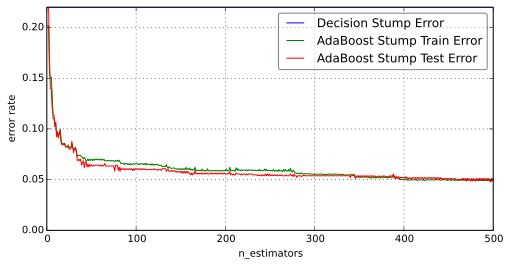

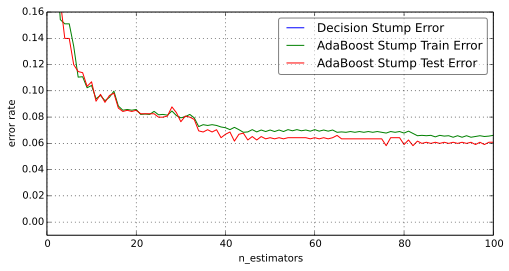

In [11]:
dataSet = spam

X = dataSet['X']
y = dataSet['y']

#Lets split the data making TtD and TD
X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)


n_estimators = 500
x_bound=[0,100]
y_bound=[-0.01,0.16]
learning_rate = 1.0

dt_stump = myDecisionTreeClassifier(max_depth=1)
dt_stump.fit(X_TD, y_TD)

ada_stump = myAdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_stump.fit(X_TD, y_TD)

spam_error_stump = plot_error2(ada_stump, dt_stump, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Stump')

spam_p13 = plot_fig(spam_error_stump, x_bound=[0,n_estimators], y_bound=[0,None])
spam_p14 = plot_fig(spam_error_stump, x_bound, y_bound)

spam_p13.show()
spam_p14.show()

Above, we see the errors for boosted decision stumps, now for the alcohol dataset. Here the Train and Test error are rendered along with the number of iterations or sequence of estimators used for prediction as well as the Test Error fora single decision stump. We see that the overall convergence is around a steady $5.5\%$ given the maximum number of iterations. Another note is how tightly our Training error mimics our Testing error, perhaps this is due to the generality of the decision classifier used.

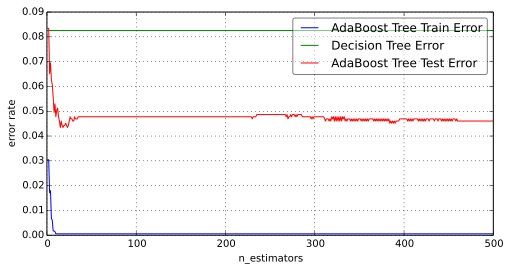

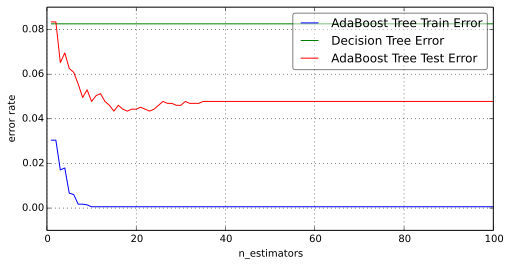

In [12]:
x_bound=[0,100]
y_bound=[-0.01, None]

dt = myDecisionTreeClassifier(max_depth=10)
dt.fit(X_TD, y_TD)

ada_tree = myAdaBoostClassifier(
    base_estimator=dt,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_tree.fit(X_TD, y_TD)

spam_error_tree = plot_error2(ada_tree, dt, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Tree')

spam_p15 = plot_fig(spam_error_tree, x_bound=[0,n_estimators], y_bound=[0,None])
spam_p16 = plot_fig(spam_error_tree, x_bound, y_bound)

spam_p15.show()
spam_p16.show()

Above, we see the errors for boosted decision trees, now for the alcohol dataset. Here our base classifier, a decision tree with a max depth of $10$ has improved over our previous decision stump, from $23\%$, now to $8.5\%$. With this base classifier improvement off the bat, our able to reduce out Test Error to $4\%$, and basically fully internalize our Train points with and Train Error of $0\%$ just after about 10 estimators.

### Dataset: Music Genre

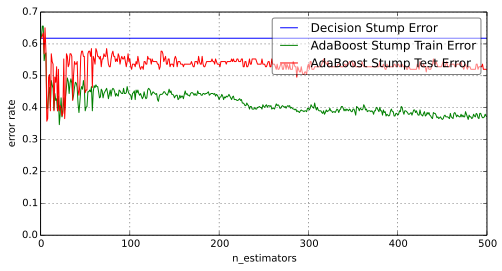

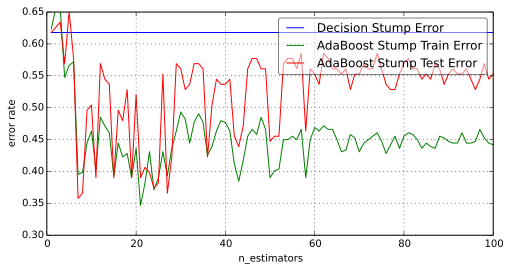

In [14]:
dataSet = musicgenre

X = dataSet['X']
y = dataSet['y']

#Lets split the data making TtD and TD
X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)


n_estimators = 500
x_bound=[0,100]
y_bound=[0.3,0.65]
learning_rate = 1.0

dt_stump = myDecisionTreeClassifier(max_depth=1)
dt_stump.fit(X_TD, y_TD)

ada_stump = myAdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_stump.fit(X_TD, y_TD)

musicgenre_error_stump = plot_error2(ada_stump, dt_stump, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Stump')

musicgenre_p5 = plot_fig(musicgenre_error_stump, x_bound=[0,n_estimators], y_bound=[0,None])
musicgenre_p6 = plot_fig(musicgenre_error_stump, x_bound, y_bound)

musicgenre_p5.show()
musicgenre_p6.show()

Above, we see the errors for boosted decision stumps, now for the music genre dataset. With numerous classes introduced, we now see the advantage of using the SAMME algorithm. We see that given a decision stump as a base classifier converging to a Test Error of $\sim 45\%$, we can not beat our previous est RF performance of $\sim 25\%$. We also see that perhaps the sparsity of the data has also resulted in a divergence of Test and Train Errors as seen before in the RF experiments previously.

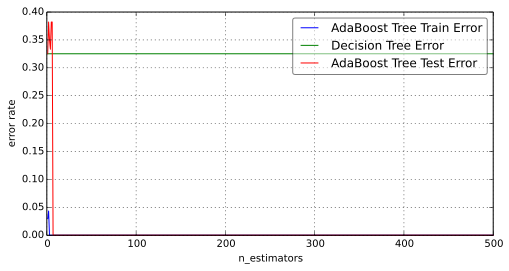

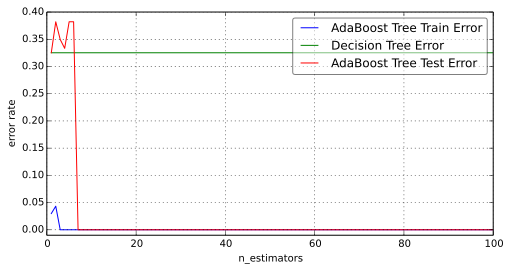

In [15]:
x_bound=[0,100]
y_bound=[-0.01, None]

dt = myDecisionTreeClassifier(max_depth=10)
dt.fit(X_TD, y_TD)

ada_tree = myAdaBoostClassifier(
    base_estimator=dt,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_tree.fit(X_TD, y_TD)

musicgenre_error_tree = plot_error2(ada_tree, dt, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Tree')

musicgenre_p7 = plot_fig(musicgenre_error_tree, x_bound=[0,n_estimators], y_bound=[0,None])
musicgenre_p8 = plot_fig(musicgenre_error_tree, x_bound, y_bound)

musicgenre_p7.show()
musicgenre_p8.show()

Above, we see the errors for boosted decision trees, now for the music genre dataset. Just as what was the case for the previous data set, once boosted trees are implied, we suddenly see a sharp convergence of our Train Error and an improvement in Test Error. Our Test Error here converges to $\sim 23\%$, the best so far from our other methods. An interesting thing here is how we see a non-monotonic behavior with Test Error over the number of boosting iterations, exemplifying how using over $100$ estimators may result in overfitting and less generality to new data.

### Dataset: Alcoholism

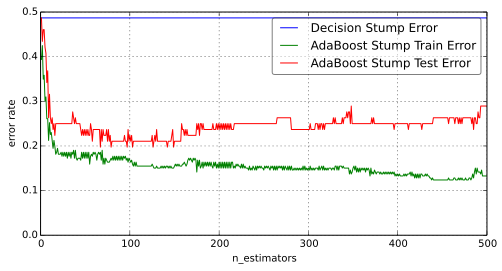

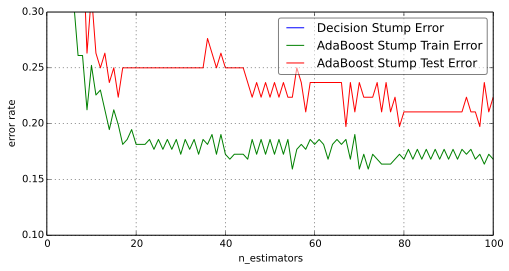

In [16]:
dataSet = alcohol

X = dataSet['X']
y = dataSet['y']

#Lets split the data making TtD and TD
X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)


n_estimators = 500
x_bound=[0,100]
y_bound=[0.1,0.3]
learning_rate = 1.0

dt_stump = myDecisionTreeClassifier(max_depth=1)
dt_stump.fit(X_TD, y_TD)

ada_stump = myAdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_stump.fit(X_TD, y_TD)

alcohol_error_stump = plot_error2(ada_stump, dt_stump, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Stump')

alcohol_p5 = plot_fig(alcohol_error_stump, x_bound=[0,n_estimators], y_bound=[0,None])
alcohol_p6 = plot_fig(alcohol_error_stump, x_bound, y_bound)

alcohol_p5.show()
alcohol_p6.show()

Above, we see the errors for boosted decision stumps, now for the alcohol dataset. We can see that boosting with just a simple stump with this dataset can result in a degree of overfitting to the training data as Test Error worsens as the number of estimators grow over $100$. Before we jump to a max depth of 10, lets try 5 first below.

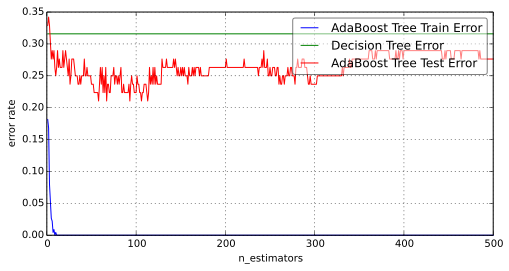

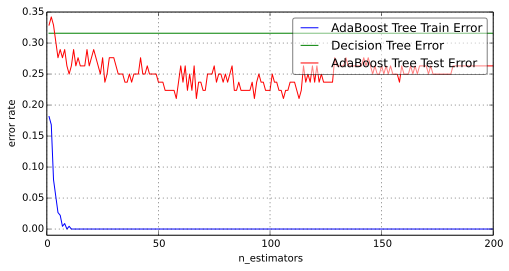

In [17]:
x_bound=[0,200]
y_bound=[-0.01, None]

dt = myDecisionTreeClassifier(max_depth=5)
dt.fit(X_TD, y_TD)

ada_tree = myAdaBoostClassifier(
    base_estimator=dt,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_tree.fit(X_TD, y_TD)

alcohol_error_tree = plot_error2(ada_tree, dt, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Tree')

alcohol_p7 = plot_fig(alcohol_error_tree, x_bound=[0,n_estimators], y_bound=[0,None])
alcohol_p8 = plot_fig(alcohol_error_tree, x_bound, y_bound)

alcohol_p7.show()
alcohol_p8.show()

Above, we see the errors for boosted decision tree with max depth of 5, now for the alcohol dataset. We can see that our tree base classifier has improved over our previous stump, but our lowest boosted Test Error has not really improved, and is now just under Tree Error. Like before, the extended depth has allowed our classifier to internalize all of it Train data and quickly converges to a $0\%$ Train Error just a few iterations.

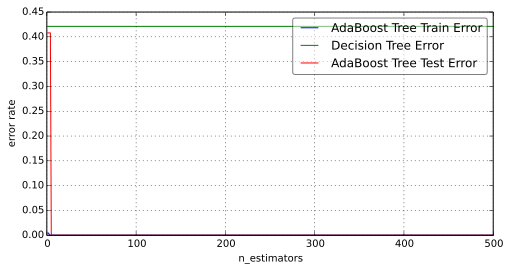

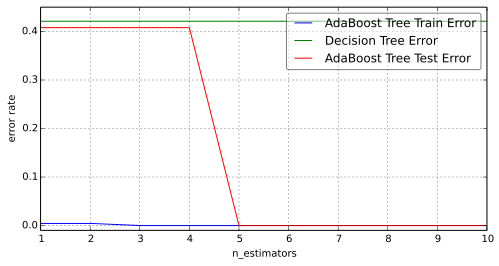

In [18]:
x_bound=[1,10]
y_bound=[-0.01, None]

dt = myDecisionTreeClassifier(max_depth=10)
dt.fit(X_TD, y_TD)

ada_tree = myAdaBoostClassifier(
    base_estimator=dt,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_tree.fit(X_TD, y_TD)

alcohol_error_tree10 = plot_error2(ada_tree, dt, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Tree')

alcohol_p9 = plot_fig(alcohol_error_tree10, x_bound=[0,n_estimators], y_bound=[0,None])
alcohol_p10 = plot_fig(alcohol_error_tree10, x_bound, y_bound)

alcohol_p9.show()
alcohol_p10.show()

Above, we see the errors for boosted decision tree with max depth of $10$, now for the alcohol dataset. This is drastic change from the trend on Test Error as we saw from the previous two base classifiers. Our Test Error now converges to $0\%$ just after 3 iterations. Personally I find this rather remarkable that this would happen, but after repeating the experiment several time with different random seeds, the system quickly converges to minimum Test Error after just 3 or 4 iterations. This perhaps show that there is an underlying pattern between the alcohol Training and Testing data sets, and just just takes a deep enough sequence of tree to recognize the complete pattern. I suppose explores the possibilities of given enough features/medical tests and a deep boosted decision tree framework, almost any feasible underlying link between ailments and proper diagnosis can be uncovered.

### Dataset: Wine

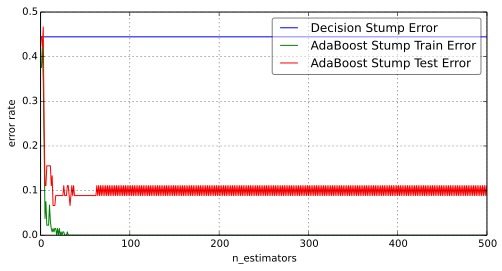

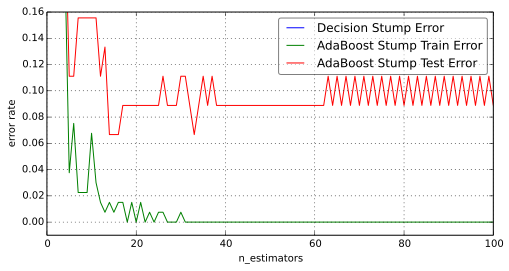

In [37]:
dataSet = wine

X = dataSet['X']
y = dataSet['y']

#Lets split the data making TtD and TD
X_TD, X_TtD, y_TD, y_TtD = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)


n_estimators = 500
x_bound=[0,100]
y_bound=[-0.01,0.16]
learning_rate = 1.0

dt_stump = myDecisionTreeClassifier(max_depth=1)
dt_stump.fit(X_TD, y_TD)

ada_stump = myAdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_stump.fit(X_TD, y_TD)

wine_error_stump = plot_error2(ada_stump, dt_stump, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Stump')

wine_p13 = plot_fig(wine_error_stump, x_bound=[0,n_estimators], y_bound=[0,None])
wine_p14 = plot_fig(wine_error_stump, x_bound, y_bound)

wine_p13.show()
wine_p14.show()

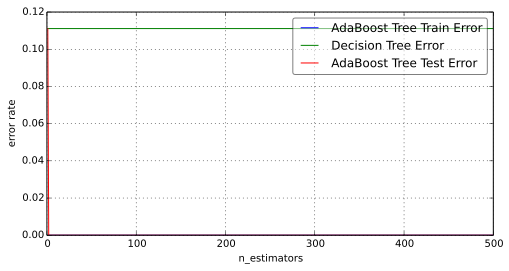

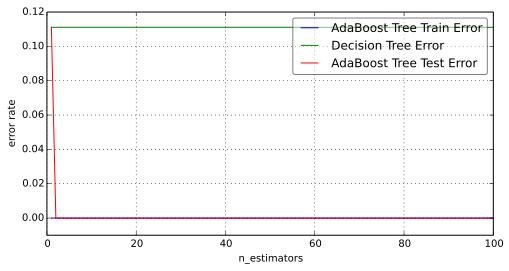

In [38]:
x_bound=[0,100]
y_bound=[-0.01, None]

dt = myDecisionTreeClassifier(max_depth=10)
dt.fit(X_TD, y_TD)

ada_tree = myAdaBoostClassifier(
    base_estimator=dt,
    learning_rate=learning_rate,
    n_estimators=n_estimators)
ada_tree.fit(X_TD, y_TD)

wine_error_tree = plot_error2(ada_tree, dt, X_TD, X_TtD, y_TD, y_TtD, n_estimators, 'Tree')

wine_p15 = plot_fig(wine_error_tree, x_bound=[0,n_estimators], y_bound=[0,None])
wine_p16 = plot_fig(wine_error_tree, x_bound, y_bound)

spam_p15.show()
spam_p16.show()